# PnP & 三角测量

对极几何中的基础矩阵（Fundamental Matrix）和本质矩阵（Essential Matrix）可以用来估计两个视角之间的相对位姿（旋转矩阵 R 和平移向量 t）。然而，这种方法只能确定方向而不能确定尺度。换句话说，通过对极几何估算出的 t 的长度是归一化的，无法直接反映真实的距离尺度，这种尺度不确定性问题导致我们无法只通过对极几何加三角化测量来获得真实的深度信息。

单目相机的图像仅包含视角信息，而没有直接的深度信息。通过三角化方法，我们可以计算出视点之间的相对深度，但由于缺乏尺度参照，这些深度值只是相对深度，通常被归一化，没有具体的单位。

所以问题的根本原因是用了对极几何来估计相机位姿，联想到之前的作业2，如果已经有一部分的深度信息，那么就可以确定出尺度，计算得到的R&t误差也会更小，所以我们这里做出一个退步：假设第一张图片的深度信息是已知的，这下我们所求出来的R和t就是没有归一化之后的数据，能够继续通过三角测量的方法求出另一张图像的深度值了。

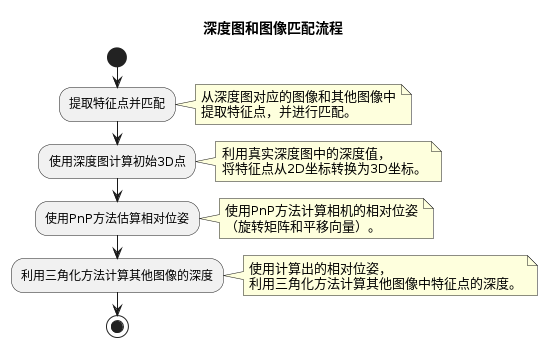

## SIFT算法

### FLANN原理

FLANN 是一个用于高效近似最近邻搜索的库，特别适用于高维数据，如图像特征匹配中的特征描述子。其基本思想是通过构建高效的索引结构（如 KD 树或 LSH）来加速最近邻搜索。

### Lowe's Ratio Test 原理
当我们进行特征匹配时，通常会找到每个特征点在另一张图像中的多个候选匹配点。Lowe's ratio test 通过比较最佳匹配（即距离最小的匹配）和次优匹配（即距离第二小的匹配）的距离比值来筛选匹配对。具体来说，如果最佳匹配的距离与次优匹配的距离之比小于某个阈值（通常为0.7），则认为该匹配对是好的，否则认为该匹配对可能是错误的匹配。

Number of good matches: 146


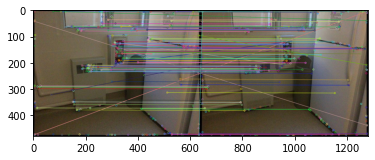

Rotation matrix:
[[ 0.99999875  0.00114304 -0.00108825]
 [-0.00114105  0.99999768  0.00182496]
 [ 0.00109033 -0.00182372  0.99999774]]
Translation vector:
[[0.00527134]
 [0.0034233 ]
 [0.00320401]]


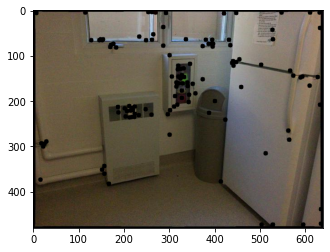

Absolute Error (Abs): 8.318577669929168
Root Mean Square Error (RMSE): 79.74305848887877
Root Mean Square Error of Logarithms (RMSE log): 0.6620372727951559


In [14]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Helper function to draw matches
def draw_matches(img1, kp1, img2, kp2, matches):
    return cv.drawMatches(img1, kp1, img2, kp2, matches, None)

# Example image and depth data loading
def load_images_and_depths(image_paths, depth_paths):
    images = [cv.imread(p) for p in image_paths]
    depths = [cv.imread(p, cv.IMREAD_UNCHANGED).astype(np.uint16) for p in depth_paths]
    depths = [(depth) * 0.001 for depth in depths]  # Adjust depth values
    return images, depths

# Extract 3D points from the first image using depth map
def extract_3d_points(image, depth, K):
    sift = cv.SIFT_create(contrastThreshold=0.02, edgeThreshold=10, sigma=1.6)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    points_2d = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    depths = np.array([depth[int(pt[1]), int(pt[0])] for pt in points_2d])
    
    # Convert 2D points to 3D points
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    points_3d = np.array([[(pt[0] - cx) * z / fx, (pt[1] - cy) * z / fy, z] for pt, z in zip(points_2d, depths)])
    
    return keypoints, descriptors, points_2d, np.array(points_3d)

# Calculate relative pose using PnP
def calculate_pnp_pose(pts_2d, pts_3d, K):
    _, R_vec, t, inliers = cv.solvePnPRansac(pts_3d, pts_2d, K, None)
    R, _ = cv.Rodrigues(R_vec)
    return R, t

# Main function to compute camera poses and depths using triangulation
def main():
    # Load images and depth data
    image_paths = ['/home/jiaoao/SLAMHW/origin_image/0_resized.jpg',
                   '/home/jiaoao/SLAMHW/origin_image/1_resized.jpg']
    depth_paths = ['/home/jiaoao/SLAMHW/scanDepth/0.png',
                   '/home/jiaoao/SLAMHW/scanDepth/1.png']
    images, depths = load_images_and_depths(image_paths, depth_paths)

    # Camera intrinsic matrix
    # K = np.array([[570.342224, 0, 320.0], 
    #               [0, 570.342224, 240.0], 
    #               [0, 0, 1]])
    K = np.array([[1165.723022 / 2,0,649.094971 / 2],
                 [0,1165.738037 / 2, 484.765015 / 2],
                 [0,0,1]])
    # Extract 3D points from the first image using depth map
    kp1, des1, pts_2d_1, pts_3d_1 = extract_3d_points(images[0], depths[0], K)
    
    # SIFT feature extraction for the second image and matching
    sift = cv.SIFT_create(contrastThreshold=0.02, edgeThreshold=10, sigma=1.6)
    kp2, des2 = sift.detectAndCompute(images[1], None)
    
    # FLANN based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    print(f'Number of good matches: {len(good_matches)}')
    
    # Draw matches
    matched_img = draw_matches(images[0], kp1, images[1], kp2, good_matches)
    plt.imshow(matched_img[:,:,::-1])
    plt.show()
    
    # Get matched 2D-3D points from the first image and 2D points from the second image
    pts_2d_1_matched = np.array([kp1[m.queryIdx].pt for m in good_matches], dtype=np.float32)
    pts_3d_1_matched = np.array([pts_3d_1[m.queryIdx] for m in good_matches], dtype=np.float32)
    pts_2d_2_matched = np.array([kp2[m.trainIdx].pt for m in good_matches], dtype=np.float32)
    
    # Ensure the matched points have the same number of points
    if len(pts_2d_1_matched) != len(pts_3d_1_matched) or len(pts_2d_1_matched) != len(pts_2d_2_matched):
        raise ValueError("The number of 2D points and 3D points must be the same.")
    
    # Calculate pose using PnP
    R, t = calculate_pnp_pose(pts_2d_2_matched, pts_3d_1_matched, K)
    print(f'Rotation matrix:\n{R}')
    print(f'Translation vector:\n{t}')
    
    # Triangulation to find depth in the second image
    projMatr1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    projMatr2 = K @ np.hstack((R, t))
    
    # Triangulate points
    points4D_hom = cv.triangulatePoints(projMatr1, projMatr2, pts_2d_1_matched.T, pts_2d_2_matched.T)
    points4D = points4D_hom / points4D_hom[3]
    points4D = points4D[:3].T
    
    # Estimated depths from triangulated points
    depths_estimated = points4D[:, 2]
    # Visualize estimated depths
    for i, pt in enumerate(pts_2d_2_matched):
        color = (0, 0, int(255 * depths_estimated[i] / np.max(depths_estimated)))
        images[1] = cv.circle(images[1], tuple(pt.astype(int)), 5, color, -1)
    
    plt.imshow(images[1][:,:,::-1])
    plt.show()

    # Calculate real depths from the second depth image
    real_depths = np.array([depths[1][int(pt[1]), int(pt[0])] for pt in pts_2d_2_matched])

    # Filter out non-positive depths
    valid_indices = np.where((depths_estimated > 0) & (real_depths > 0))
    depths_estimated = depths_estimated[valid_indices]
    real_depths = real_depths[valid_indices]

    # Calculate error metrics
    abs_error = np.mean(np.abs(real_depths - depths_estimated))
    rmse = np.sqrt(np.mean((real_depths - depths_estimated) ** 2))
    rmse_log = np.sqrt(np.mean((np.log1p(real_depths) - np.log1p(depths_estimated)) ** 2))

    print(f'Absolute Error (Abs): {abs_error}')
    print(f'Root Mean Square Error (RMSE): {rmse}')
    print(f'Root Mean Square Error of Logarithms (RMSE log): {rmse_log}')

if __name__ == "__main__":
    main()


### ORB算法

Number of good matches: 279


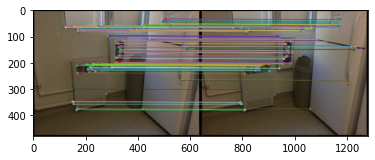

Rotation matrix:
[[ 9.99996681e-01  9.74843061e-04 -2.38469137e-03]
 [-9.66926998e-04  9.99994026e-01  3.31843715e-03]
 [ 2.38791208e-03 -3.31612032e-03  9.99991651e-01]]
Translation vector:
[[0.00761032]
 [0.00066222]
 [0.00453701]]


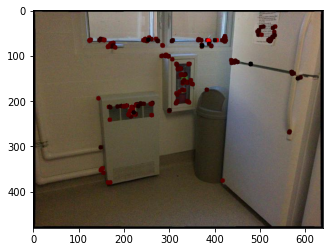

Absolute Error (Abs): 0.6785183322029328
Root Mean Square Error (RMSE): 0.9481239539715275
Root Mean Square Error of Logarithms (RMSE log): 0.25049101647519895


In [5]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Helper function to draw matches
def draw_matches(img1, kp1, img2, kp2, matches):
    return cv.drawMatches(img1, kp1, img2, kp2, matches, None)

# Example image and depth data loading
def load_images_and_depths(image_paths, depth_paths):
    images = [cv.imread(p) for p in image_paths]
    depths = [cv.imread(p, cv.IMREAD_UNCHANGED).astype(np.uint16) for p in depth_paths]
    depths = [(depth) * 0.001 for depth in depths]  # Adjust depth values
    return images, depths

# Extract 3D points from the first image using depth map
def extract_3d_points(image, depth, K):
    orb = cv.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    
    points_2d = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    depths = np.array([depth[int(pt[1]), int(pt[0])] for pt in points_2d])
    
    # Convert 2D points to 3D points
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    points_3d = np.array([[(pt[0] - cx) * z / fx, (pt[1] - cy) * z / fy, z] for pt, z in zip(points_2d, depths)])
    
    return keypoints, descriptors, points_2d, np.array(points_3d)

# Calculate relative pose using PnP
def calculate_pnp_pose(pts_2d, pts_3d, K):
    _, R_vec, t, inliers = cv.solvePnPRansac(pts_3d, pts_2d, K, None)
    R, _ = cv.Rodrigues(R_vec)
    return R, t

# Main function to compute camera poses and depths using triangulation
def main():
    # Load images and depth data
    image_paths = ['/home/jiaoao/SLAMHW/origin_image/0_resized.jpg',
                   '/home/jiaoao/SLAMHW/origin_image/1_resized.jpg']
    depth_paths = ['/home/jiaoao/SLAMHW/scanDepth/0.png',
                   '/home/jiaoao/SLAMHW/scanDepth/1.png']
    images, depths = load_images_and_depths(image_paths, depth_paths)

    # Camera intrinsic matrix
    # K = np.array([[570.342224, 0, 320.0], 
    #               [0, 570.342224, 240.0], 
    #               [0, 0, 1]])
    K = np.array([[1165.723022 / 2,0,649.094971 / 2],
                 [0,1165.738037 / 2, 484.765015 / 2],
                 [0,0,1]])
    # Extract 3D points from the first image using depth map
    kp1, des1, pts_2d_1, pts_3d_1 = extract_3d_points(images[0], depths[0], K)
    
    # ORB feature extraction for the second image and matching
    orb = cv.ORB_create()
    kp2, des2 = orb.detectAndCompute(images[1], None)
    
    # FLANN based matcher
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH,
                        table_number=6,  # 12
                        key_size=12,     # 20
                        multi_probe_level=1)  # 2
    search_params = dict(checks=50)  # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    print(f'Number of good matches: {len(good_matches)}')
    
    # Draw matches
    matched_img = draw_matches(images[0], kp1, images[1], kp2, good_matches)
    plt.imshow(matched_img[:,:,::-1])
    plt.show()
    
    # Get matched 2D-3D points from the first image and 2D points from the second image
    pts_2d_1_matched = np.array([kp1[m.queryIdx].pt for m in good_matches], dtype=np.float32)
    pts_3d_1_matched = np.array([pts_3d_1[m.queryIdx] for m in good_matches], dtype=np.float32)
    pts_2d_2_matched = np.array([kp2[m.trainIdx].pt for m in good_matches], dtype=np.float32)
    
    # Ensure the matched points have the same number of points
    if len(pts_2d_1_matched) != len(pts_3d_1_matched) or len(pts_2d_1_matched) != len(pts_2d_2_matched):
        raise ValueError("The number of 2D points and 3D points must be the same.")
    
    # Calculate pose using PnP
    R, t = calculate_pnp_pose(pts_2d_2_matched, pts_3d_1_matched, K)
    print(f'Rotation matrix:\n{R}')
    print(f'Translation vector:\n{t}')
    
    # Triangulation to find depth in the second image
    projMatr1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    projMatr2 = K @ np.hstack((R, t))
    
    # Triangulate points
    points4D_hom = cv.triangulatePoints(projMatr1, projMatr2, pts_2d_1_matched.T, pts_2d_2_matched.T)
    points4D = points4D_hom / points4D_hom[3]
    points4D = points4D[:3].T
    
    # Estimated depths from triangulated points
    depths_estimated = points4D[:, 2]
    # Visualize estimated depths
    for i, pt in enumerate(pts_2d_2_matched):
        color = (0, 0, int(255 * depths_estimated[i] / np.max(depths_estimated)))
        images[1] = cv.circle(images[1], tuple(pt.astype(int)), 5, color, -1)
    
    plt.imshow(images[1][:,:,::-1])
    plt.show()

    # Calculate real depths from the second depth image
    real_depths = np.array([depths[1][int(pt[1]), int(pt[0])] for pt in pts_2d_2_matched])

    # Filter out non-positive depths
    valid_indices = np.where((depths_estimated > 0) & (real_depths > 0))
    depths_estimated = depths_estimated[valid_indices]
    real_depths = real_depths[valid_indices]

    # Calculate error metrics
    abs_error = np.mean(np.abs(real_depths - depths_estimated))
    rmse = np.sqrt(np.mean((real_depths - depths_estimated) ** 2))
    rmse_log = np.sqrt(np.mean((np.log1p(real_depths) - np.log1p(depths_estimated)) ** 2))

    print(f'Absolute Error (Abs): {abs_error}')
    print(f'Root Mean Square Error (RMSE): {rmse}')
    print(f'Root Mean Square Error of Logarithms (RMSE log): {rmse_log}')

if __name__ == "__main__":
    main()
